In [1]:
import rankedDelegation as rd
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pulp
import time
from IPython.utils import io
np.random.seed(42)

# Load the data

In [24]:
path = "C:\\Users\\Theo Delemazure\\Documents\\ENS\\Stage Berlin\\data\\"
list_datasets = [{"path":"twitter\\soc-twitter-follows.mtx","delimiter":" ","name":"Twitter"}, 
                 {"path":"twitter\\higgs-social_network.edgelist","delimiter":" ","name":"Higgs"}, 
                {"path":"slashdot\\Slashdot0902.txt","delimiter":"\t","name":"Slashdot"}, 
                {"path":"twitter\\out.munmun_twitter_social","delimiter":" ","name":"Twittercycle"}]

def load_data(index):
    full_path = path + list_datasets[index]["path"]
    list_edges = np.genfromtxt(full_path, delimiter=list_datasets[index]["delimiter"], dtype=int)
    nb_nodes= int(np.max(list_edges))+1
    list_nodes = np.arange(nb_nodes)
    list_edges_temp = []
    count_out = np.zeros(nb_nodes)
    count_in = np.zeros(nb_nodes)

    for (a, b) in tqdm(list_edges):
        if a != b:
            count_out[a] += 1
            count_in[b] += 1
            list_edges_temp.append((a,b))

    list_edges = list_edges_temp
    
    return {"edges":list_edges, "out": count_out, "in": count_in, "nb_nodes": nb_nodes}

In [18]:
def plot_degrees_distrib(tab, title="Distribution of degrees"):
    plt.figure(figsize=(15,5))
    plt.hist(count_out, bins=int(np.max(tab)))
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel("count")
    plt.xlabel("degree")
    plt.title(title)
    plt.show()

In [19]:
def create_election(data, p=0.8):
    n = data["nb_nodes"]
    list_edges = data["edges"]
    popularity = data["in"]
    
    e = rd.Election()
    outedges_dict = {}
    for (a, b) in tqdm(list_edges):
        if a not in outedges_dict:
            outedges_dict[a] = []
        outedges_dict[a].append(b)
    
    # Add casting voters
    for i in tqdm(range(n)):
        x = np.random.choice([0,1,2],p=[p,(1-p)/2,(1-p)/2])
        if x == 0:
            v = rd.Voter()
        else:
            v = rd.Voter(vote=x)
        e.add_voter(v)

    # Add edges
    L = e.list_voters
    delegatees_list = [[] for i in range(n)]
    n_edges = 0
    
    for r_1 in tqdm(range(n)):
        if L[r_1].vote is not None or r_1 not in outedges_dict:
            continue
        delegatees = outedges_dict[r_1]
        proba = popularity[delegatees]
        proba /= proba.sum()
        ordering = np.random.choice(delegatees, p=proba, replace=False, size=len(proba))
        for ind in ordering:
            delegatees_list[r_1].append(L[ind])
            
    for voter in L:
        voter.delegate(delegatees_list[voter.id])
    
    return e 

In [20]:
def save_election(e, results, title=""):
    L = []
    C = []
    timestamp = int(time.time())
    for v in tqdm(e.list_voters):
        for i, d in enumerate(v.delegatees):
            L.append((v.id, d.id, i+1))
        if v.vote is not None:
            C.append((v.id, 1))
        else:
            C.append((v.id, 0))
        
    np.savetxt("Save/edges_%s_%i.csv"%(title,timestamp), L)
    np.savetxt("Save/nodes_%s_%i.csv"%(title,timestamp), C)
    results.to_csv("Save/results_%s_%i.csv"%(title, timestamp))

In [21]:
def print_results(e):
    print("Winner is %i"%e.winner)
    print("Results : ",e.results)
    c_gurus = 0
    for v in e.list_voters:
        if v.vote is not None:
            c_gurus += 1
    s = np.log(c_gurus)
    
    print("Maximum rank is %i"%e.max_rank)
    print("Maximum length is %i"%e.max_length)
    print("Average length is %.2f"%e.mean_length)
    print("Maximum guru power is %i"%e.max_power)
    print("Entropy guru power is %.2f (best : %.2f)"%(e.power_entropy, s))
    print("Maximum sum of rank is %i"%e.max_sum)
    print("Sum of rank is %i (only for confluent rules)"%e.sum_rank)
    print("Avg rank is %.2f (only for confluent rules)"%e.avg_rank)
    plt.figure(figsize=(15,5))
    plt.hist(e.list_powers,bins=1000)
    plt.xlim(1,10000)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Guru distribution of power")
    plt.xlabel("Power")
    plt.ylabel("Number of nodes")
    plt.show()
    print("Unpopularity is %i (only for confluent rules)"%e.unpopularity)

In [22]:
def distrib_voters(e):
    tab = np.zeros(4)
    for v in e.list_voters:
        if v.vote is not None:
            tab[0] += 1
        elif v.guru is not None:
            tab[1] += 1
        elif len(v.delegatees) > 0:
            tab[2] += 1
        else:
            tab[3] += 1
    tab /= np.sum(tab)
    return tab

def distrib_voters_avg(data, n_trys=10):
    tab = np.zeros(4)
    for _ in tqdm(range(n_trys)):
        with io.capture_output() as captured:
            e = create_election(data)
            e.attribute_gurus(rd.rules.naive_DFD)
        tab += distrib_voters(e)
    tab /= n_trys
    return tab

# Try all rules on one election (with unpopularity)

Winner is 1
Results :  [[128387, 1], [125742, 2]]
Maximum rank is 33
Maximum length is 4
Average length is 1.73
Maximum guru power is 2549
Entropy guru power is 8.68 (best : 11.30)
Maximum sum of rank is 35
Sum of rank is 200765 (only for confluent rules)
Avg rank is 1.16 (only for confluent rules)


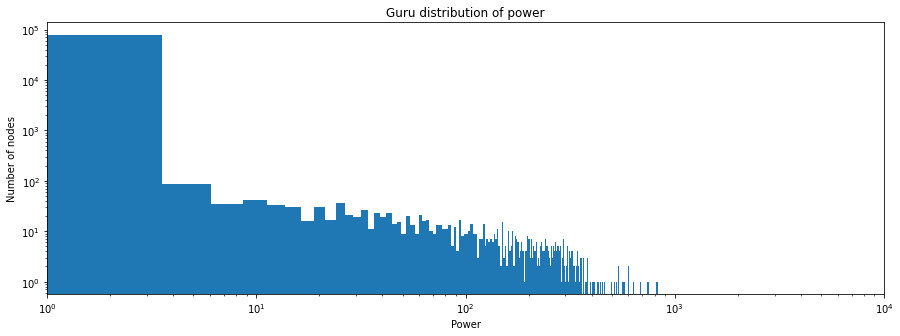

In [83]:
e.attribute_gurus(rd.rules.naive_BFD)
print_results(e)

Winner is 2
Results :  [[27375, 1], [46207, 2]]
Maximum rank is 7
Maximum length is 35
Average length is 7.22
Maximum guru power is 16285
Entropy guru power is 6.13 (best : 9.70)
Maximum sum of rank is 37
Sum of rank is 57975 (only for confluent rules)
Avg rank is 1.01 (only for confluent rules)


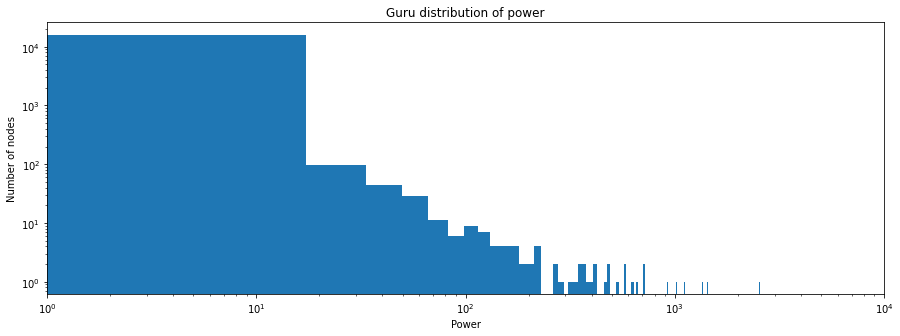

Unpopularity is -60 (only for confluent rules)


In [62]:
e.attribute_gurus(rd.rules.naive_DFD)
print_results(e)

Winner is 1
Results :  [[37348, 1], [36234, 2]]
Maximum rank is 5
Maximum length is 7
Average length is 2.14
Maximum guru power is 2749
Entropy guru power is 7.29 (best : 9.70)
Maximum sum of rank is 10
Sum of rank is 71372 (only for confluent rules)
Avg rank is 1.25 (only for confluent rules)


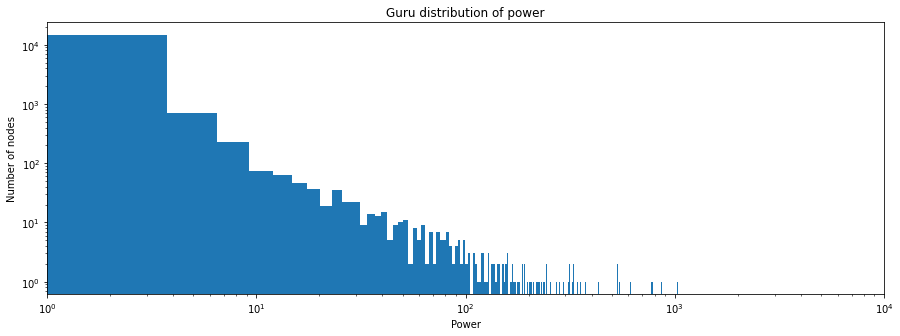

Unpopularity is 10778 (only for confluent rules)


In [63]:
e.attribute_gurus(rd.rules.minsum)
print_results(e)

Winner is 2
Results :  [[34864, 1], [38718, 2]]
Maximum rank is 5
Maximum length is 17
Average length is 3.33
Maximum guru power is 2316
Entropy guru power is 6.92 (best : 9.70)
Maximum sum of rank is 19
Sum of rank is 66253 (only for confluent rules)
Avg rank is 1.16 (only for confluent rules)


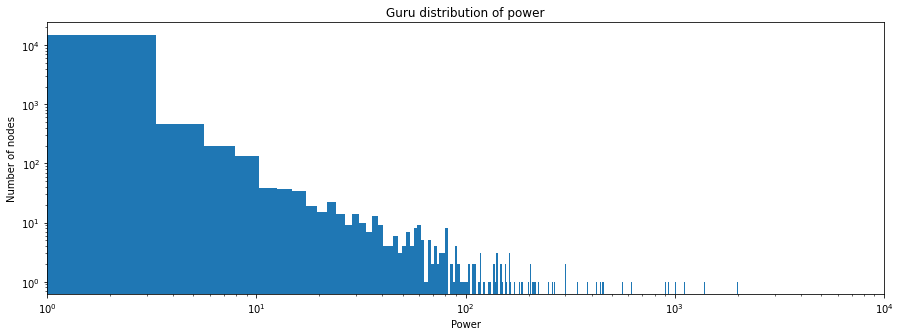

Unpopularity is 8215 (only for confluent rules)


In [64]:
e.attribute_gurus(rd.rules.diffusion)
print_results(e)

Winner is 1
Results :  [[37212, 1], [36370, 2]]
Maximum rank is 5
Maximum length is 16
Average length is 3.04
Maximum guru power is 2810
Entropy guru power is 6.94 (best : 9.70)
Maximum sum of rank is 17
Sum of rank is 63092 (only for confluent rules)
Avg rank is 1.10 (only for confluent rules)


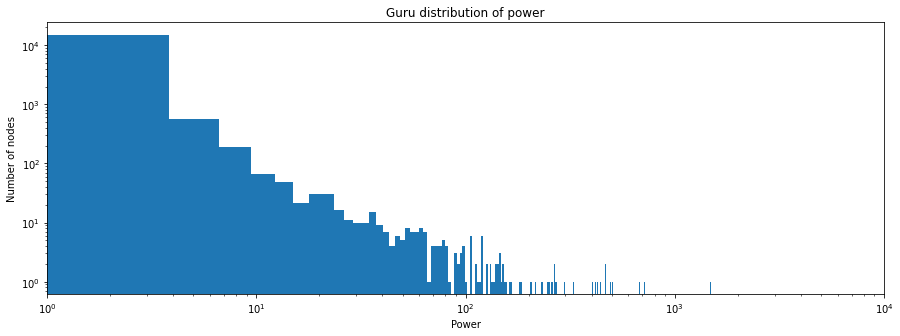

Unpopularity is 5054 (only for confluent rules)


In [65]:
e.attribute_gurus(rd.rules.lexrank)
print_results(e)

Winner is 2
Results :  [[34030, 1], [39552, 2]]
Maximum rank is 5
Maximum length is 31
Average length is 6.24
Maximum guru power is 12517
Entropy guru power is 6.11 (best : 9.70)
Maximum sum of rank is 33
Sum of rank is 58040 (only for confluent rules)
Avg rank is 1.01 (only for confluent rules)


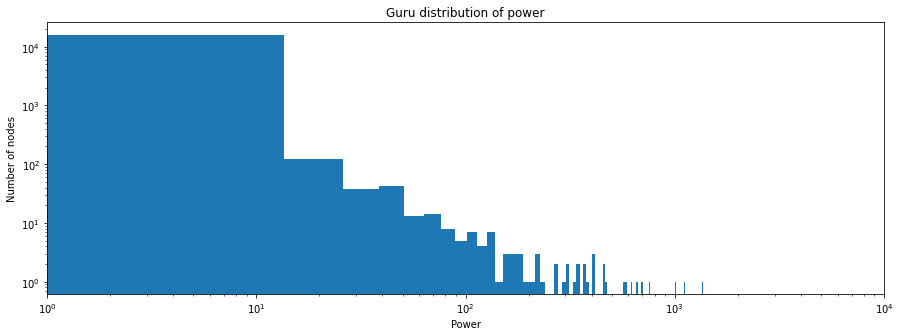

Unpopularity is 2 (only for confluent rules)


In [66]:
e.attribute_gurus(rd.rules.minSumRank)
print_results(e)

# Save one election

In [ ]:
def run_election(index):
    data= load_data(index)

    rules = [rd.rules.naive_BFD, rd.rules.minsum, rd.rules.naive_DFD, 
             rd.rules.diffusion, rd.rules.lexrank, rd.rules.minSumRank]

    rules_str = ["BFD", "MinSumPath", "DFD","Diffusion", "LexRank","MinArb"]
    
    metrics_str = ["Max Rank", "Max Length", "Avg Length","Max Power", "Max representation",
                "Power entropy", "Max Sum", "Sum of Rank", "Avg Rank", "Unpopularity"]

    seed = np.random.randint(100000)
    print(seed)
    np.random.seed(seed)
    n_rules = len(rules)
    tab_results = np.zeros((10, n_rules))
    e = create_election(data)

    for i, rule in tqdm(enumerate(rules)):
        e.attribute_gurus(rule)
        tab_results[0, i] += e.max_rank
        tab_results[1, i] += e.max_length
        tab_results[2, i] += e.mean_length
        tab_results[3, i] += e.max_power
        tab_results[4, i] += e.max_representation
        tab_results[5, i] += e.power_entropy
        tab_results[6, i] += e.max_sum
        tab_results[7, i] += e.sum_rank
        tab_results[8, i] += e.avg_rank
        tab_results[9, i] += e.unpopularity

    df = pd.DataFrame(tab_results.T, index=rules_str, columns=metrics_str)
    save_election(e, df, list_datasets[index]["name"])

for _ in range(2):
    run_election(3)

 15%|█▍        | 123340/834797 [00:00<00:00, 1225152.29it/s]

14260


100%|██████████| 465018/465018 [00:01<00:00, 293011.05it/s]
6it [3:10:30, 1905.05s/it]
 16%|█▌        | 135415/834797 [00:00<00:00, 1343783.69it/s]

20767


100%|██████████| 465018/465018 [00:01<00:00, 341698.89it/s]
3it [1:21:35, 1577.76s/it]

# Average on 10 elections (without LP)

In [118]:
rules = [rd.rules.naive_BFD, rd.rules.minsum, rd.rules.naive_DFD, 
         rd.rules.diffusion, rd.rules.lexrank]
n_rules = len(rules)
tab_results = np.zeros((8, n_rules))
n_iter = 10

for _ in tqdm(range(n_iter)):
    with io.capture_output() as captured:
        e = create_election(nb_nodes, list_edges, count_in)
        
    for i, rule in enumerate(rules):
        e.attribute_gurus(rule)
        tab_results[0, i] += e.max_rank
        tab_results[1, i] += e.max_length
        tab_results[2, i] += e.mean_length
        tab_results[3, i] += e.max_power
        tab_results[4, i] += e.power_entropy
        tab_results[5, i] += e.max_sum
        tab_results[6, i] += e.sum_rank
        tab_results[7, i] += e.avg_rank
        
tab_results /= n_iter

100%|██████████| 10/10 [18:18<00:00, 109.89s/it]


In [119]:
df = pd.DataFrame(data=tab_results.T, 
                  index=["BFD", "MinSumPath", "DFD","Diffusion", "LexRank"], 
                  columns=[ "Max Rank", "Max Length", "Avg Length","Max Power", "Power entropy",
                           "Max Sum", "Sum of Rank", "Avg Rank"])

df

,Max Rank,Max Length,Avg Length,Max Power,Power entropy,Max Sum,Sum of Rank,Avg Rank
BFD,35.4,4.1,1.734675,1721.4,8.748406,36.7,201210.2,1.161552
MinSumPath,18.6,6.7,2.254558,4976.2,8.254202,19.9,187207.0,1.080721
DFD,18.5,10.9,3.020724,8701.2,7.910911,23.8,174701.2,1.008521
Diffusion,18.5,9.9,2.698995,7671.4,8.024499,20.9,185651.7,1.071746
LexRank,18.5,9.3,2.660234,7613.8,8.040930,20.9,183545.0,1.059586
